# Mean Variance Estimation

In [1]:
# %pip install lightning-uq-box

## Theoretic Foundation

The Gaussian model, also referred to as Mean Variance Estimation, was first studied in [Nix, 1994](https://ieeexplore.ieee.org/abstract/document/374138) and further used in [Sluijterman 2023](https://arxiv.org/abs/2302.08875), this is a deterministic model that predicts the parameters of a Gaussian distribution

$$
    f_{\theta}(x^{\star}) = (\mu_{\theta}(x^\star),\sigma_{\theta}(x^\star))
$$

in a single forward pass, where standard deviations $\sigma_{\theta}(x^\star)$ can be used as a measure of data uncertainty. To this end the network now outputs two parameters and is trained with the Gaussian negative log-likelihood (NLL) as a loss objective [Kendall, 2017](https://proceedings.neurips.cc/paper_files/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf), that is given by

$$
    \mathcal{L}(\theta, (x^{\star}, y^{\star})) = \frac{1}{2}\text{ln}\left(2\pi\sigma_{\theta}(x^{\star})^2\right) + \frac{1}{2\sigma_{\theta}(x^{\star})^2}\left(\mu_{\theta}(x^{\star})-y^{\star}\right)^2.
$$

Correspondingly, the model prediction consists of a predictive mean, $\mu_{\theta}(x^\star)$, and the predictive uncertainty - the parameters of a Gaussian distribution - in this case the standard deviation $\sigma_{\theta}(x^\star)$.


## Imports

In [2]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

In [3]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [4]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [5]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

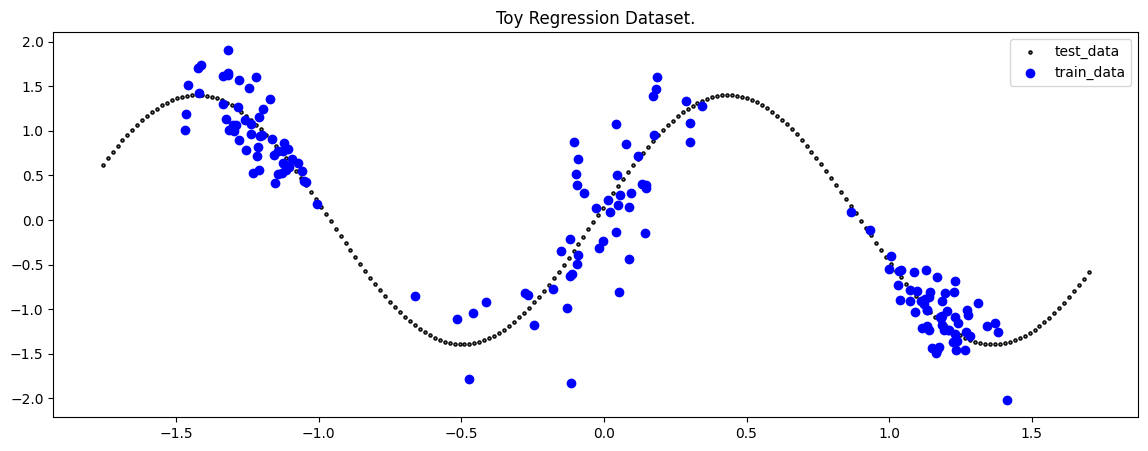

In [6]:
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [12]:
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=1, activation_fn=nn.Tanh(), predict_sigma=True)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible. 

We can first train with the MSE loss, and only adapt the parameters of the mean prediction for the number of ```burnin_eochs``` for more stable training, before switching to the NLL loss. 

In [13]:
mve_model = MVERegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-3), burnin_epochs=5
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [14]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    accelerator="cpu",  # use distributed training
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jonase/opt/miniconda3/envs/luq-dev/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Training our model is now easy:

In [15]:
trainer.fit(mve_model, dm)

Missing logger folder: /var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/tmpmwqy2wq5/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/Users/jonase/opt/miniconda3/envs/luq-dev/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


TypeError: 'NoneType' object is not subscriptable

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

In [ ]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile.

In [ ]:
preds = mve_model.predict_step(X_test)

## Evaluate Predictions

In [ ]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Mean Variance Estimation Network",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction.

In [ ]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)